In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

class_names = [
    "shirt, blouse", "top, t-shirt, sweatshirt", "sweater", "cardigan", "jacket", "vest",
    "pants", "shorts", "skirt", "coat", "dress", "jumpsuit", "cape", "glasses", "hat",
    "headband, head covering, hair accessory", "tie", "glove", "watch", "belt", "leg warmer",
    "tights, stockings", "sock", "shoe", "bag, wallet", "scarf", "umbrella", "hood",
    "collar", "lapel", "epaulette", "sleeve", "pocket", "neckline", "buckle", "zipper",
    "applique", "bead", "bow", "flower", "fringe", "ribbon", "rivet", "ruffle", "sequin",
    "tassel"
]

def build_rgb_colormap(cmap_name: str, n_colors: int) -> np.ndarray:
    cmap = plt.cm.get_cmap(cmap_name)
    sampled = cmap(np.linspace(0, 1, n_colors))      # (n,4)
    return (sampled[:, :3] * 255).astype(np.uint8)   # (n,3) uint8 RGB

# ---------------------------------------------------------------------
# Convert a YOLO-Seg label file  →  integer mask array
# ---------------------------------------------------------------------
def yolo_label_to_mask(label_path, img_shape):
    """
    Parameters
    ----------
    label_path : str
        Path to YOLO-Seg label file.  Format per line:
            <class_id> x1 y1 x2 y2 ... xn yn          (coords are 0–1)
    img_shape  : (H, W, 3) or (H, W)
        The *original* image shape so we know the mask size.

    Returns
    -------
    mask : int32 ndarray, shape (H, W)
        Each pixel holds its class-id, or -1 if no label.
    """
    H, W = img_shape[:2]
    mask = np.full((H, W), -1, np.int32)        # start “all background”

    with open(label_path, "r") as f:
        for ln in f:
            if not ln.strip():
                continue
            parts = ln.strip().split()
            cid   = int(parts[0])
            pts   = np.array(list(map(float, parts[1:])), dtype=np.float32).reshape(-1, 2)
            pts[:, 0] *= W                      # x → px
            pts[:, 1] *= H                      # y → px
            cv2.fillPoly(mask,
                         [pts.round().astype(np.int32)],
                         int(cid))               # paint with class-id
    return mask


# ----------
# Visualise 
# ----------
def visualize_yolo_label(label_path,
                         class_names,
                         image_path,
                         alpha=0.6):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    mask  = yolo_label_to_mask(label_path, image.shape)

    # ---------- colour only *valid* class-ids ------------------------
    n_classes = len(class_names)
    colormap  = (plt.cm.get_cmap('gist_ncar')(np.linspace(0, 1, n_classes))[:, :3] * 255).astype(np.uint8)
    valid     = (mask >= 0) & (mask < n_classes)

    colour_mask = np.zeros((*mask.shape, 3), np.uint8)
    colour_mask[valid] = colormap[mask[valid]]

    blended     = cv2.addWeighted(image, 1 - alpha, colour_mask, alpha, 0)
    display_img = image.copy()
    display_img[valid] = blended[valid]

    # ---------- draw -------------------------------------------------
    plt.figure(figsize=(8, 8))
    plt.imshow(display_img); plt.axis('off')
    plt.title("Image + YOLO-Seg mask")

    present = np.unique(mask[valid])
    if present.size:
        legend = [Patch(facecolor=colormap[c]/255.0, edgecolor='none',
                        label=f"{class_names[c]} ({c})") for c in present]
        plt.legend(handles=legend, loc='lower center',
                   bbox_to_anchor=(0.5, -0.05), ncol=3,
                   fontsize='small', frameon=False)

    plt.tight_layout(); plt.show()


/tmp/ipykernel_12508/2833533692.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap  = (plt.cm.get_cmap('gist_ncar')(np.linspace(0, 1, n_classes))[:, :3] * 255).astype(np.uint8)


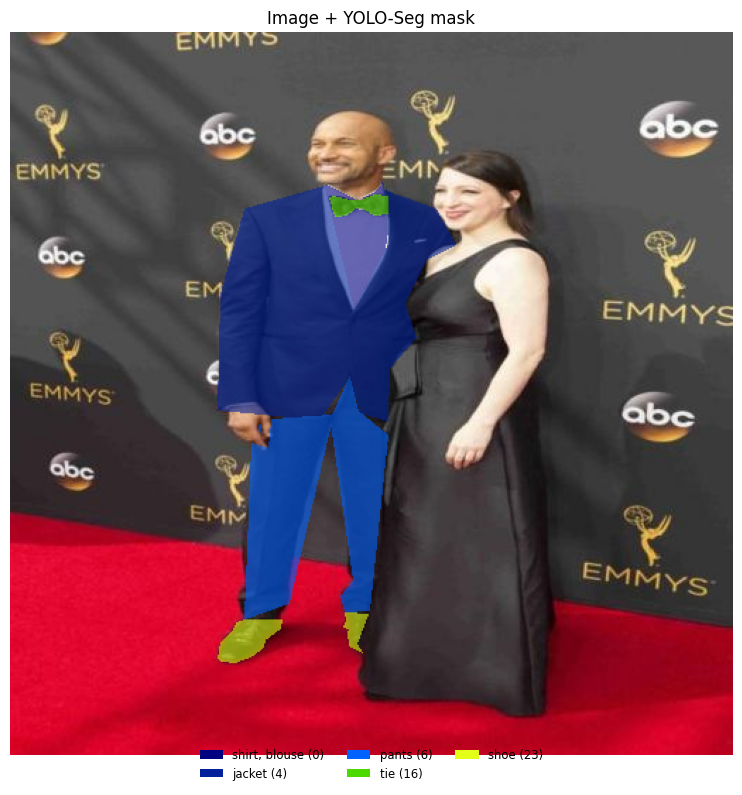

In [7]:
# ------------- example -------------
image_path = 'dataset/images/train/0a5f42e306446625d6f000bf664f5051.jpg'
mask_path  = 'dataset/labels/train/0a5f42e306446625d6f000bf664f5051.txt'

visualize_yolo_label(mask_path, class_names, image_path)